In [73]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
np.set_printoptions(precision=3, suppress=True)
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
import numpy as np
np.set_printoptions(precision=3, suppress=True)
from sklearn.preprocessing import MinMaxScaler
from NuRadioReco.utilities import units, fft
import cWGANGP_model_def

from matplotlib import pyplot as plt, cm
import seaborn as sns
from radiotools import plthelpers as php
from pickle import load


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


3 Physical GPUs, 3 Logical GPUs


In [74]:
data = np.load('/mnt/md0/aholmberg/data/signal_had_12_5deg.npy')
condition = data[:,:2]
shower_n = data[:,3]
signals = data[:,3:]
signals_filtered = np.load('/mnt/md0/aholmberg/data/signal_had_12_filtered_5deg.npy')

N = 896
condition_norm = condition.copy()
condition_norm[:,0] = np.log(condition_norm[:, 0])
cond_scaler = MinMaxScaler().fit(condition_norm)
condition_norm  = cond_scaler.transform(condition_norm)

In [75]:
name = 'critic_conv_gen_trans_adam_5deg_incept1'
g_model = keras.models.load_model(f'/mnt/md0/aholmberg/GAN_models/gen_{name}/', compile=False)
g_model.compile()
#d_model = keras.models.load_model('/mnt/md0/aholmberg/GAN_models/GAN_discriminator_conv_degenerate_case/', compile=False)

latent_dim = 112

test_split = 0.1
ind = int(signals_filtered.shape[0]*(1-test_split))

test_signals = signals_filtered[ind:, :]
test_conditions = condition[ind:, :]
test_conditions_norm = condition_norm[ind:, :]


test_signal = test_signals[6:16, :]
test_condition = test_conditions[6:16, :]
test_condition_norm = test_conditions_norm[6:16, :]
latent_vec = tf.random.normal((10, latent_dim))

In [76]:
pred_signals = g_model([latent_vec, test_condition_norm], training=False)
pred_signals.shape

TensorShape([10, 896])

In [77]:
pred_signals_scaled = np.zeros_like(pred_signals)
for i in range(pred_signals.shape[0]):
    pred_signals_scaled[i,:] = pred_signals[i,:]/(1e19/test_condition[i, 0])

Text(0, 0.5, 'amplitude [V/m]')

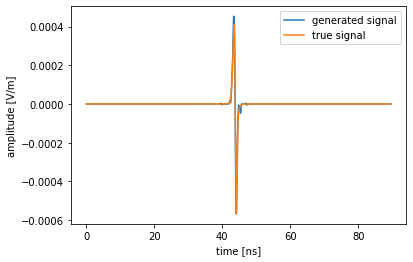

In [78]:
x = np.linspace(0,89.6, 896)
plt.plot(x, pred_signals_scaled[1,:], label='generated signal')
plt.plot(x, test_signal[1,:], label='true signal')
plt.legend()
plt.xlabel('time [ns]')
plt.ylabel('amplitude [V/m]')
#plt.savefig('gensig.png')

In [82]:
dt = 1e-10 * units.second
sr = 1/dt
ff = np.fft.rfftfreq(N, dt)

pred_spectrum = np.zeros((10, 449))
real_spectrum = np.zeros((10, 449))
for i in range(10):
    pred_spectrum[i, :] = np.abs(fft.time2freq(pred_signals_scaled[i, :], sampling_rate=sr))
    real_spectrum[i, :] = np.abs(fft.time2freq(test_signal[i, :], sampling_rate=sr))

Text(0.5, 0.98, 'Signal and spectrum for 10 generated signals and 10 real signals with different shower profiles, E=2.22e+16 [eV] $\\theta$=54.02 [$^\\circ$]')

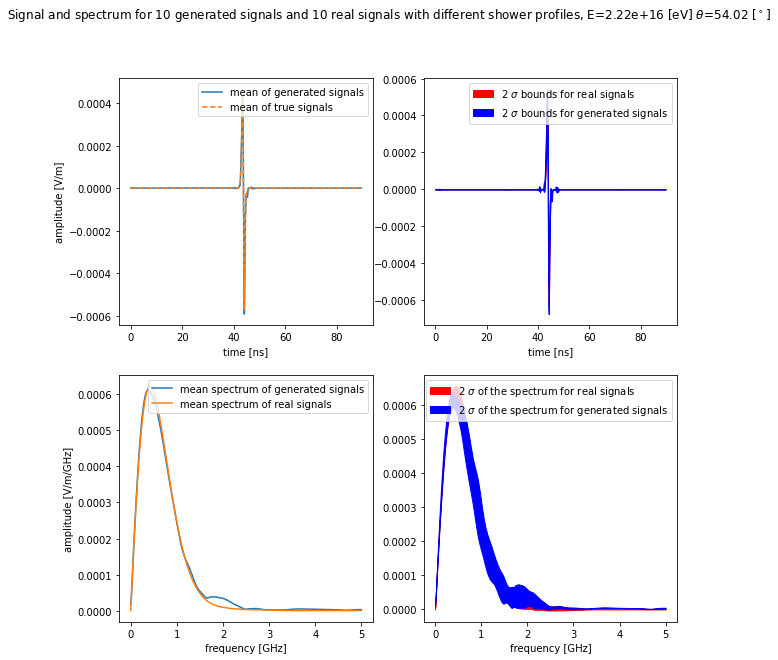

In [85]:
mean_pred = np.mean(pred_signals_scaled, axis=0)
std_pred = np.std(pred_signals_scaled, axis=0)
mean_real = np.mean(test_signal, axis=0)
std_real = np.std(test_signal, axis=0)

mean_pred_spectrum = np.mean(pred_spectrum, axis=0)
std_pred_spectrum = np.std(pred_spectrum, axis=0)
mean_real_spectrum = np.mean(real_spectrum, axis=0)
std_real_spectrum = np.std(real_spectrum, axis=0)

fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=False)
ax[0, 0].plot(x, mean_pred, label=f'mean of generated signals')
ax[0, 0].plot(x, mean_real, '--',label=f'mean of true signals')

ax[0, 1].fill_between(x, mean_real-2*std_real, mean_real+2*std_real, label=f'2 $\sigma$ bounds for real signals', color='r')
ax[0, 1].fill_between(x, mean_pred-2*std_pred, mean_pred+2*std_pred, label=f'2 $\sigma$ bounds for generated signals', color='b')

ax[1, 0].plot(ff, mean_pred_spectrum, label='mean spectrum of generated signals')
ax[1, 0].plot(ff, mean_real_spectrum, label='mean spectrum of real signals')

ax[1, 1].fill_between(ff, mean_real_spectrum-2*std_real_spectrum, mean_real_spectrum+2*std_real_spectrum, label=f'2 $\sigma$ of the spectrum for real signals', color='r')
ax[1, 1].fill_between(ff, mean_pred_spectrum-2*std_pred_spectrum, mean_pred_spectrum+2*std_pred_spectrum, label=f'2 $\sigma$ of the spectrum for generated signals', color='b')

ax[0, 0].legend(loc=1)
ax[0, 1].legend(loc=1)
ax[1, 0].legend(loc=1)
ax[1, 1].legend(loc=1)
ax[0, 0].set_xlabel('time [ns]')
ax[0, 1].set_xlabel('time [ns]')
ax[0, 0].set_ylabel('amplitude [V/m]')
ax[1, 0].set_xlabel('frequency [GHz]')
ax[1, 0].set_ylabel('amplitude [V/m/GHz]')
ax[1, 1].set_xlabel('frequency [GHz]')
theta = r'$\theta$'
deg = r'$^\circ$'
fig.suptitle(f'Signal and spectrum for 10 generated signals and 10 real signals with different shower profiles, E={test_condition[0,0]:.2e} [eV] {theta}={test_condition[0, 1]/ units.deg :.2f} [{deg}]')

In [86]:
test_signals = signals_filtered[ind+6:, :]
test_conditions = condition[ind+6:, :]
test_conditions_norm = condition_norm[ind+6:, :]
latent_vec = tf.random.normal((test_conditions.shape[0], latent_dim))

In [90]:
pred_signals = g_model([latent_vec, test_conditions_norm], training=False)
pred_signals.shape

4090

In [88]:
pred_signals_scaled = np.zeros_like(pred_signals)
for i in range(pred_signals.shape[0]):
    pred_signals_scaled[i,:] = pred_signals[i,:]/(1e19/test_conditions[i, 0])

In [92]:
pred_spectrum = np.zeros((pred_signals.shape[0], 449), dtype=complex)
real_spectrum = np.zeros((pred_signals.shape[0], 449), dtype=complex)
for i in range(pred_signals.shape[0]):
    pred_spectrum[i, :] = fft.time2freq(pred_signals_scaled[i, :], sampling_rate=sr)
    real_spectrum[i, :] = fft.time2freq(test_signals[i, :], sampling_rate=sr)

In [ ]:
mean_pred = np.zeros((409, 896))
mean_real = np.zeros((409, 896))
mean_pred_spectrum = np.zeros((409, 449))
mean_real_spectrum = np.zeros((409, 449))
for i in range(0, pred_signals.shape[0], 10):
    

In [13]:
#history = np.load('history.npy', allow_pickle=True)
history = pd.read_pickle(f'GAN_losses/history_{name}.pkl')
history.head()

,d_loss,g_loss,d_cost,gp,batch
0,-1.085606,1.224253,-1.212940,0.012733,0
1,-2.659018,3.051292,-2.949821,0.029080,1
2,-4.208922,5.203851,-4.954996,0.074607,2
3,-6.238714,7.011207,-7.058869,0.082015,3
4,-7.076596,8.523011,-8.385939,0.130934,4


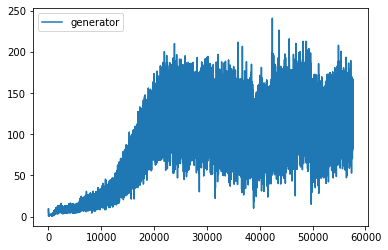

In [14]:
#g = sns.relplot(x="batch", y="d_loss", kind="line", data=history)
plt.plot(history['g_loss'], label='generator') #history['batch'], 
plt.legend()

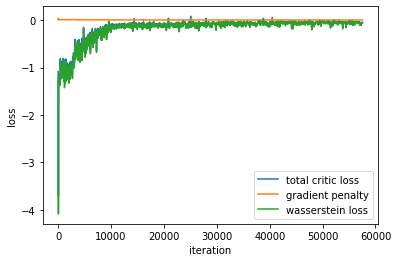

In [19]:
plt.plot(history['d_loss'][::50], label='total critic loss')
plt.plot(history['gp'][::50], label='gradient penalty')
plt.plot(history['d_cost'][::50], label='wasserstein loss')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig('wloss.png')

Text(0, 0.5, 'wasserstein loss')

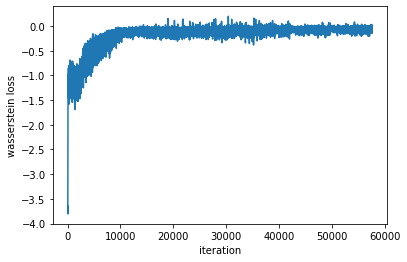

In [16]:
plt.plot(history['d_loss'][45:])
plt.xlabel('iteration')
plt.ylabel('wasserstein loss')

In [9]:
keras.utils.plot_model(g_model, to_file='g_model_simple.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
